In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import os

In [7]:
import time
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time

In [8]:
data_dir = "D:/github/archive/chest_xray/balanced"
batch_size = 32
image_size = 128  # or 256

# Transform with resizing and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}


In [9]:
datasets_dict = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
                 for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}

class_names = datasets_dict['train'].classes

In [10]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.fc(x)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
loss_train = []
acc_train = []
for epoch in range(50):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start = time.time()
    temp_loss = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        temp_loss = loss.detach().cpu().item()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    acc_train.append(acc)
    loss_train.append(temp_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")
    print(f"Hey! the calculations are done in {_time(start, time.time())}")


Epoch 1, Loss: 61.3056, Accuracy: 90.37%
Hey! the calculations are done in 1min 11.58sec
Epoch 2, Loss: 35.4660, Accuracy: 94.95%
Hey! the calculations are done in 1min 4.34sec
Epoch 3, Loss: 29.8950, Accuracy: 95.41%
Hey! the calculations are done in 1min 3.77sec
Epoch 4, Loss: 24.7921, Accuracy: 96.19%
Hey! the calculations are done in 1min 3.37sec
Epoch 5, Loss: 21.0962, Accuracy: 96.81%
Hey! the calculations are done in 1min 3.9sec
Epoch 6, Loss: 19.9892, Accuracy: 96.92%
Hey! the calculations are done in 1min 3.91sec
Epoch 7, Loss: 16.8876, Accuracy: 97.43%
Hey! the calculations are done in 1min 3.51sec
Epoch 8, Loss: 15.7942, Accuracy: 97.58%
Hey! the calculations are done in 1min 3.62sec
Epoch 9, Loss: 16.0052, Accuracy: 97.77%
Hey! the calculations are done in 1min 3.62sec
Epoch 10, Loss: 14.6300, Accuracy: 97.85%
Hey! the calculations are done in 1min 3.67sec
Epoch 11, Loss: 17.3618, Accuracy: 97.55%
Hey! the calculations are done in 1min 4.28sec
Epoch 12, Loss: 14.3903, Accur

In [13]:
correct = 0
total = 0
start = time.time()
loss_test = []
all_labels = []
all_preds = []
all_probs = []


with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_test.append(loss.detach().cpu().item())
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Store probabilities for ROC-AUC curve (assuming binary classification)
        all_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Hey! the calculations are done in {_time(start, time.time())}")

Test Accuracy: 77.40%
Hey! the calculations are done in 10.58sec


Precision: 0.8244
Recall: 0.7740
F1-score: 0.7449


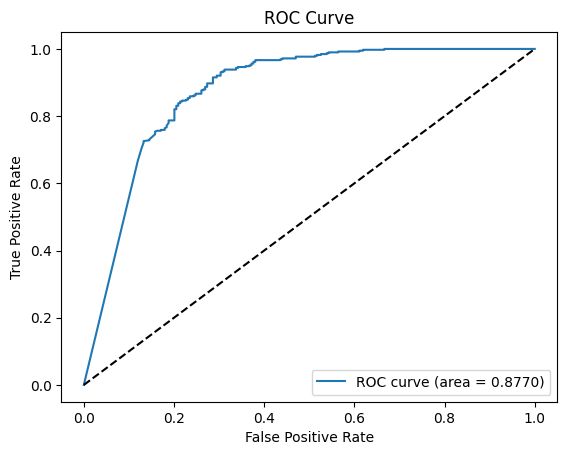

ROC-AUC Score: 0.8770


In [16]:

# Compute Precision, Recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Compute ROC-AUC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

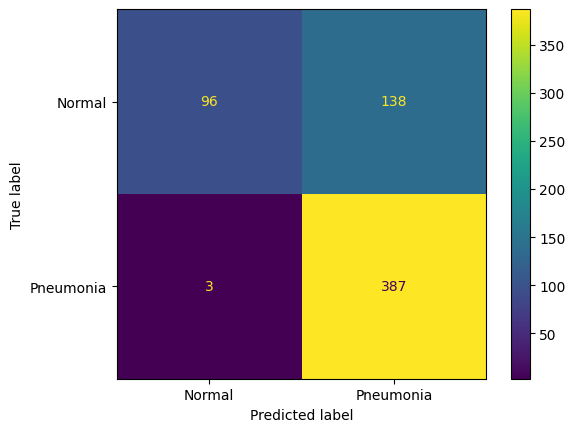

In [18]:
Categories = ['Normal', 'Pneumonia']
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Categories).plot()